In [66]:
import numpy as np
from typing import Literal
from tem import * 

def qubo_index(i, N, zero=True):
    max = N*(N-1)/2
    if i > max or i<1:
        return None
    
    for j in range(1, N+1):
        Nj = N-j
        if i > Nj:
            i -= Nj
        else:
            if zero:
                return (j-1, j+i-1)
            return (j, j+i)


In [67]:
kernel = lambda i,j : 1/(1+(i -j)**2)
n0 = 7
K = np.fromfunction(kernel, (n0, n0))
D = diff_matrix_three_point(n0, t="") # difference matrix

In [68]:
# QUBO formulation
L = D@K
M = L.T@L
n0 = M.shape[0]
save_M00 = M[0,0]

i, j = np.indices(M.shape)

# Adjust the principal axis effect 
# to reduce possiblity of trivial solution, all zero and ones. 
M[i==j] = 0.5

q_r_diff = M.diagonal()
J_r_diff = M[np.triu_indices(n0, k = 1)]

linear_r = { (i, i): q_r_diff[i] for i in range(0,n0)}
in_list_r= [qubo_index(i, n0) for i in range(1, int(n0*(n0-1)/2)+1)]
quadratic_r = { in_list_r[i]: M[*in_list_r[i]] for i in range(0, int(n0*(n0-1)/2))}

Quad = {**linear_r, **quadratic_r}

In [69]:
import pennylane as qml

In [70]:
# Gate model setting
# Circuit setting
n_wires = n0
wires = range(n_wires)

basis_hamiltonian_initial = [qml.PauliX(i) for i in range(0, n0)]

basis_hamiltonian_dig = [qml.PauliZ(i) for i in range(0, n0)]
basis_hamiltonian_off = [qml.PauliZ(i)@qml.PauliZ(j) for (i, j) in in_list_r]

# Adabatic parameter setting
mu = 10 # Initial hamitlonian weight
coeff_X = n0*[-mu] # pauli x coeff

# Below solution hamiltonian

#M[i==j] = save_M00 # restore the original quadratic form
M[i==j] = 0
dig_coeff = list(np.sqrt(M.diagonal()))
off_coeff = [M[i, j] for (i, j) in in_list_r]

coeff = np.array(coeff_X + dig_coeff + off_coeff)
basis_hamiltonian = basis_hamiltonian_initial + basis_hamiltonian_dig + basis_hamiltonian_off

In [71]:
H_init = qml.Hamiltonian(-np.ones(n0), basis_hamiltonian_initial)
H_solve = qml.Hamiltonian(dig_coeff+off_coeff ,basis_hamiltonian_dig + basis_hamiltonian_off)

# Anealer D-Wave

In [72]:
from dwave.system import DWaveSampler, EmbeddingComposite
sampler = EmbeddingComposite(DWaveSampler())

ModuleNotFoundError: No module named 'dwave'

In [73]:
samples_d_wave= sampler.sample_qubo(
    Quad, 
    num_reads=1000, 

SyntaxError: incomplete input (3738157965.py, line 3)

In [13]:
print(samples_d_wave.record[0:5])

NameError: name 'samples_d_wave' is not defined

# Gate Model simulator

In [74]:
from matplotlib import pyplot as plt

In [75]:
from pennylane.templates import ApproxTimeEvolution

In [126]:
dev_local_sim = qml.device('default.qubit', wires=n_wires, shots=500)

In [127]:
@qml.qnode(dev_local_sim)
def circuit_time_evolve(time, initial_weight, 
                        steps=5, trroter_num=2 ,
                        mode="exp", Hamiltonian=H_solve):
    
    n_list = [i for i in range(0,n0)]
    for i in n_list:
        qml.Hadamard(wires=i)
    
    #qml.Hadamard(wires=n_list)

    dt = time/steps
    n1 = int(n0*(n0+1)/2)
    
    if initial_weight <0:
        initial_weight = -initial_weight
    coeff_X = n0*[-initial_weight]
    coeff = np.array(coeff_X + dig_coeff + off_coeff)
    
    for i in range(0, steps+1):
        t = i*dt/time
        t_evol = np.array(n0*[1-t] + n1*[t])
        t_coeff = t_evol * coeff
        H_t = qml.Hamiltonian(t_coeff, basis_hamiltonian)
        
        ApproxTimeEvolution(H_t, dt, trroter_num)
    if mode=="exp":
        return qml.expval(Hamiltonian)
    elif mode=="count":
        return qml.counts()
    elif mode =="prob":
        return qml.probs(n_list)

In [128]:
T = 10
iw=  4
steps = 10
trroter_num =2

In [129]:
sample = circuit_time_evolve(T, 
    initial_weight=iw, 
    steps=steps, 
    trroter_num = trroter_num , 
    mode="count")

In [130]:
sample

{'0000000': 9,
 '0000001': 13,
 '0000010': 5,
 '0000011': 8,
 '0000101': 2,
 '0000110': 2,
 '0000111': 1,
 '0001001': 6,
 '0001010': 2,
 '0001011': 4,
 '0001100': 6,
 '0001101': 2,
 '0001110': 3,
 '0010010': 7,
 '0010100': 18,
 '0010110': 7,
 '0010111': 2,
 '0011000': 7,
 '0011011': 3,
 '0011100': 19,
 '0011101': 1,
 '0011110': 5,
 '0011111': 7,
 '0100000': 4,
 '0100001': 3,
 '0100011': 2,
 '0100100': 6,
 '0100101': 3,
 '0100111': 7,
 '0101000': 2,
 '0101001': 10,
 '0101010': 7,
 '0101011': 1,
 '0101101': 3,
 '0101110': 1,
 '0101111': 5,
 '0110000': 1,
 '0110011': 3,
 '0110100': 8,
 '0110101': 9,
 '0110110': 6,
 '0110111': 4,
 '0111000': 2,
 '0111001': 3,
 '0111010': 1,
 '0111100': 1,
 '0111110': 1,
 '0111111': 4,
 '1000000': 8,
 '1000010': 1,
 '1000011': 3,
 '1000101': 2,
 '1000110': 2,
 '1000111': 1,
 '1001000': 6,
 '1001001': 9,
 '1001010': 10,
 '1001011': 14,
 '1001100': 3,
 '1001101': 1,
 '1001110': 1,
 '1010000': 1,
 '1010001': 3,
 '1010010': 2,
 '1010011': 1,
 '1010101': 7,
 '10

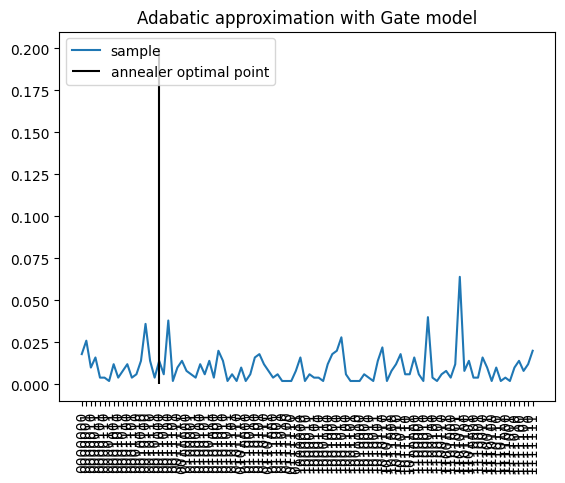

In [131]:
sample_n = np.array(list(sample.values()))
plt.plot(sample.keys(), sample_n/500)
plt.xticks(rotation = 90)
plt.title("Adabatic approximation with Gate model")
plt.vlines(17, 0, 0.2, colors=["k"])
plt.legend(["sample", "annealer optimal point"], loc=2)
plt.show()

# IBM Q computer Running

**Prerequisites**

* IBM Quantum account and its API token

Assume that you already installed `pennylane` package, you need next packages to run your Pennylane circuit on IBM quantum computer.

* qiskit
* qiskit-aear
* pennylane-qiskit

```
pip install qiskit, qiskit-aear, pennylane-qiskit
```

After you generate account on IBM server and get api token, save the configuration to your local qiskit environment.

In [ ]:
from qiskit import IBMQ
IBMQ.save_account("yout token value")

When you finished the above configuration, you can use IBM backends on your local python environment without additional account configuration.

Let's see some possible backends of IBMQ.

In [86]:
provider = IBMQ.load_account()
provider.backends()

ibmqfactory.load_account:WARNING:2023-08-07 00:48:39,147: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_lagos') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairo

`IBMQSimulator` is a HPC qubit simulator class and `IBMQBackend` is a real quantum devices class.

Choose one of the backend and make Pennylane `device` as like your previous codes.

In [100]:
dev_ibmq = qml.device(
    "qiskit.ibmq", wires=7, 
    backend='ibm_nairobi', 
    provider=provider, 
    shots= 500,
    ibmqx_token=ibmq_token)

In [101]:
@qml.qnode(dev_ibmq)
def circuit_time_evolve_IBM(time, initial_weight, 
                        steps=5, trroter_num=2 ,
                        mode="exp", Hamiltonian=H_solve):
    
    n_list = [i for i in range(0,n0)]
    for i in n_list:
        qml.Hadamard(wires=i)
    
    #qml.Hadamard(wires=n_list)

    dt = time/steps
    n1 = int(n0*(n0+1)/2)
    
    if initial_weight <0:
        initial_weight = -initial_weight
    coeff_X = n0*[-initial_weight]
    coeff = np.array(coeff_X + dig_coeff + off_coeff)
    
    for i in range(0, steps+1):
        t = i*dt/time
        t_evol = np.array(n0*[1-t] + n1*[t])
        t_coeff = t_evol * coeff
        H_t = qml.Hamiltonian(t_coeff, basis_hamiltonian)
        
        ApproxTimeEvolution(H_t, dt, trroter_num)
    if mode=="exp":
        return qml.expval(Hamiltonian)
    elif mode=="count":
        return qml.counts()
    elif mode =="prob":
        return qml.probs(n_list)

In [132]:
T = 10
iw=  4
steps = 10
trroter_num =2

Run quantum circuit on real quantum device may takes several minutes or hours. The circuit will be registered on work queue of each device and treated sequentially.

While they are on the queue, you can see the IBMQ dashboard and there is a queued task. You can also see qiskit and qasm version of your circuit on the dashboard.

In [133]:
sample_ibm_real = circuit_time_evolve_IBM(T, 
    initial_weight=iw, 
    steps=steps, 
    trroter_num = trroter_num , 
    mode="count")

c:\Users\qwqwh\Documents\GitHub\Quantum_Computing\.conda\Lib\site-packages\pennylane_qiskit\qiskit_device.py:475: UserWarning: ibmqx_token is not a recognized runtime option and may be ignored by the backend.
  self._current_job = self.backend.run(compiled_circuits, shots=self.shots, **self.run_args)
ibmqjob._wait_for_completion:ERROR:2023-08-07 13:28:34,028: Maximum retries exceeded: Error checking job status due to a network error.


IBMQJobApiError: 'Error checking job status due to a network error: "HTTPSConnectionPool(host=\'api.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/Network/ibm-q/Groups/open/Projects/main/Jobs/cj85cpbqmesganiqlu5g/status/v/1 (Caused by NewConnectionError(\'<urllib3.connection.HTTPSConnection object at 0x0000020E19862550>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed\'))"'

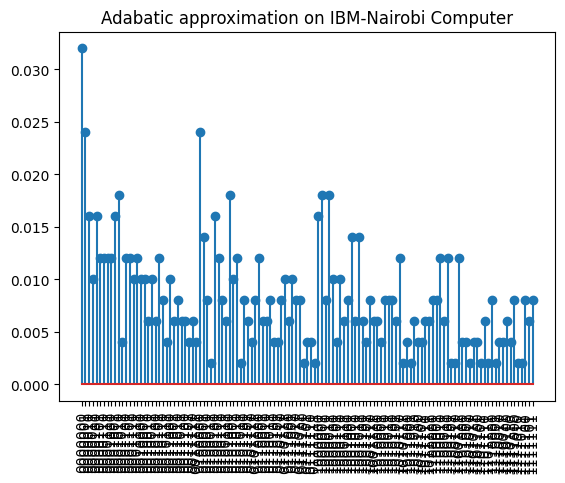

In [107]:
sample_n = np.array(list(sample_ibm_real.values()))
plt.stem(sample_ibm_real.keys(), sample_n/500)
plt.xticks(rotation = 90)
plt.title("Adabatic approximation on IBM-Nairobi Computer")
plt.show()

In [105]:
sample_ibm_real

{'0000000': 16,
 '0000001': 12,
 '0000010': 8,
 '0000011': 5,
 '0000100': 8,
 '0000101': 6,
 '0000110': 6,
 '0000111': 6,
 '0001000': 6,
 '0001001': 8,
 '0001010': 9,
 '0001011': 2,
 '0001100': 6,
 '0001101': 6,
 '0001110': 5,
 '0001111': 6,
 '0010000': 5,
 '0010001': 5,
 '0010010': 3,
 '0010011': 5,
 '0010100': 3,
 '0010101': 6,
 '0010110': 4,
 '0010111': 2,
 '0011000': 5,
 '0011001': 3,
 '0011010': 4,
 '0011011': 3,
 '0011100': 3,
 '0011101': 2,
 '0011110': 3,
 '0011111': 2,
 '0100000': 12,
 '0100001': 7,
 '0100010': 4,
 '0100011': 1,
 '0100100': 8,
 '0100101': 6,
 '0100110': 4,
 '0100111': 3,
 '0101000': 9,
 '0101001': 5,
 '0101010': 6,
 '0101011': 1,
 '0101100': 4,
 '0101101': 3,
 '0101110': 2,
 '0101111': 4,
 '0110000': 6,
 '0110001': 3,
 '0110010': 3,
 '0110011': 4,
 '0110100': 2,
 '0110101': 2,
 '0110110': 4,
 '0110111': 5,
 '0111000': 3,
 '0111001': 5,
 '0111010': 4,
 '0111011': 4,
 '0111100': 1,
 '0111101': 2,
 '0111110': 2,
 '0111111': 1,
 '1000000': 8,
 '1000001': 9,
 '10000